# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. 

Поставлена задача — построить модель, которая будет её предсказывать температуру сплава на выходе. 

В нашем распоряжении датасеты, полученные из разных источников.

Данные состоят из нескольких файлов:

data_arc_new.csv — данные об электродах;

data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

data_gas_new.csv — данные о продувке сплава газом;

data_temp_new.csv — результаты измерения температуры;

data_wire_new.csv — данные о проволочных материалах (объём);

data_wire_time_new.csv — данные о проволочных материалах (время).

Импортируем необходимые библиотеки для работы.

In [1]:
pip install matplotlib==3.7.3

     |████████████████████████████████| 11.6 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 321 kB 61.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 58.7 MB/s eta 0:00:01
     |████████████████████████████████| 18.2 MB 22.7 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to us

In [2]:
!pip install phik

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 81.9 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.4 which is incompatible.


In [3]:
!pip install shap

     |████████████████████████████████| 539 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 16.8 MB 49.5 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.3.0 requires numpy>=1.23, but you have numpy 1.22.4 which is incompatible.


In [4]:
pip install numpy==1.22

     |████████████████████████████████| 16.8 MB 2.5 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.3.0 requires numpy>=1.23, but you have numpy 1.22.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import phik
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import shap

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder, RobustScaler)

test_size = 0.25
RANDOM_STATE = 251124

## Загрузка данных

Загрузим датасеты.

In [6]:
data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')

In [7]:
#функция для просмотра первичной информации о датасете
def inspection(df):
    q = display(df)
    a = df.info()
    b = df.duplicated().sum()
    w = df.isna().sum()
    return q, a, print('Количество явных дубликатов:', '\n', b), print('Количество пропусков в колонках:', '\n', w)
    

Взглянем на данные 

### Датасет data_arc_new — данные об электродах

In [8]:
inspection(data_arc_new)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
Количество явных дубликатов: 
 0
Количество пропусков в колонках: 
 key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


(None, None, None, None)

In [9]:
data_arc_new['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

В датасете имеем 14876 строк, 5 колонок.

Наименование колонок необходимо привести к общепринятому виду. Так же у колонок 'Начало нагрева дугой' и 'Конец нагрева дугой' изменим тип данных на datetime.

Дубликатов нет. Пропусков в колонках нет.

Имеем признаки:
- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.

Можем заметить, что некоторые партии нагревают по нескольку раз.

### Датасет data_bulk_new — данные о подаче сыпучих материалов (объём)

In [10]:
inspection(data_bulk_new)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
Количество явных дубликатов: 
 0
Количество пропусков в колонках: 
 key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5  

(None, None, None, None)

В датасете имеем 3129 строк, 16 колонок. Наименование колонок необходимо привести к общепринятому виду.

Дубликатов нет. В каждой колонке есть пропуски.

Признаки:
- key — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала.

Признаки Bulk 1 … Bulk 15 обозначают объем подаваемого материала. Значит имеем пропуски в тех местах, где материал не подавали. Следовательно можем на месте пропусков поставить 0.

### Датасет data_bulk_time_new — данные о подаче сыпучих материалов (время)

In [11]:
inspection(data_bulk_time_new)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
Количество явных дубликатов: 
 0
Количество пропусков в колонках: 
 key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6    

(None, None, None, None)

В датасете 3129 строк, так же 16 колонок. Так же необходимо привести наименования колонок в общему виду.

Признаки:
- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.

Дубликатов нет. Имеются пропуски по всем колонкам, кроме колонки key.

Датасет имеет только признак по времени подачи материала. Данный признак не имеет значения, поэтому в не будем использовать датасет в дальнейшем.

### Датасет data_gas_new — данные о продувке сплава газом

In [12]:
inspection(data_gas_new)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
Количество явных дубликатов: 
 0
Количество пропусков в колонках: 
 key      0
Газ 1    0
dtype: int64


(None, None, None, None)

Датасет имеет 3239 строк, 2 колонки. Пропусков нет. дубликатов нет.

Признаки:
- key — номер партии;
- Газ 1 — объём подаваемого газа.

### Датасет data_temp_new — результаты измерения температуры

In [13]:
inspection(data_temp_new)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
Количество явных дубликатов: 
 0
Количество пропусков в колонках: 
 key                0
Время замера       0
Температура     3427
dtype: int64


(None, None, None, None)

In [14]:
data_temp_new[data_temp_new['Температура'] < 1400]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


Датасет имеет 18092 строки, 3 колонки. Имеются пропуски в колонке Температура.
Дубликатов нет.

Признаки:

- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.

### Датасет data_wire_new — данные о проволочных материалах (объём)

In [15]:
inspection(data_wire_new)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
Количество явных дубликатов: 
 0
Количество пропусков в колонках: 
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


(None, None, None, None)

В датасете имеем 3081 строки, 10 колонок. Пропуски по всем колонкам, за исключением key.
Дубликатов нет.

Признаки:
- key — номер партии;
- Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

По аналогии с датасетом о подаче сыпучих материалов - пропуски заменим на 0.

### Датасет data_wire_time_new — данные о проволочных материалах (время)

In [16]:
inspection(data_wire_time_new)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
Количество явных дубликатов: 
 0
Количество пропусков в колонках: 
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


(None, None, None, None)

В датасете 3081 строка, 10 колонок. Дубликатов нет. Имеются пропуски.

Признаки:
- key — номер партии;
- Wire 1 … Wire 9 — время подачи проволочных материалов

Датасет имеет только признак по времени подачи материала. Данный признак не имеет значения, поэтому в не будем использовать датасет в дальнейшем.

#### Промежуточный вывод по разделу:

Загружены и проведен первичный осмотр датасетов. Всего 7 датасетов. На первый взгляд по всем таблицам необходимо исправить внешний вид - привести наименования колонок к общему виду. 

В датасетах имеются пропуски, в ходе проведения исследовательского анализа необходимо выявить природу появления пропусков, и заполнить или убрать строки, которые нет возможности заместить.

Данные таблиц data_wire_time_new и data_wire_time_new не будем использовать в дальнейшей работе, т.к. они имеют только данные о времени подчи добавок в расплавленную сталь.



## Исследовательский анализ  и предобработка данных

### data_arc_new

In [17]:
data_arc_new.head(20)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [18]:
#заменим наименования колонок
data_arc_new = data_arc_new.rename(columns={'Начало нагрева дугой' : 'start_arc_heating',
                                            'Конец нагрева дугой' : 'end_arc_heating',
                                            'Активная мощность' : 'active_power',
                                            'Реактивная мощность' : 'reactive_power'})
#проверим
data_arc_new.head(1)

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.30513,0.211253


In [19]:
#изменим тип данных
data_arc_new['start_arc_heating'] = pd.to_datetime(data_arc_new['start_arc_heating'])
data_arc_new['end_arc_heating'] = pd.to_datetime(data_arc_new['end_arc_heating'])
data_arc_new.dtypes

key                           int64
start_arc_heating    datetime64[ns]
end_arc_heating      datetime64[ns]
active_power                float64
reactive_power              float64
dtype: object

In [20]:
data_arc_new.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [21]:
#создадим функцию для постраения гистограмм и боксплот 
def boxplot_hist(df, column):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(df[column])
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Диаграмма размаха для {column}')
    sns.boxplot(x=df[column])
    df[column].describe()

In [22]:
arc_new_num = ['active_power', 'reactive_power']

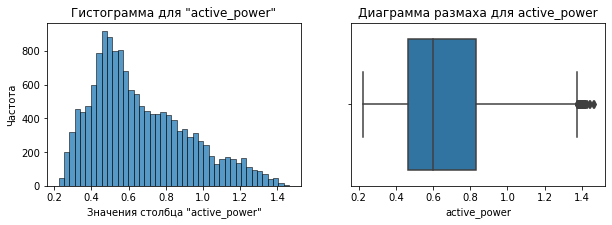

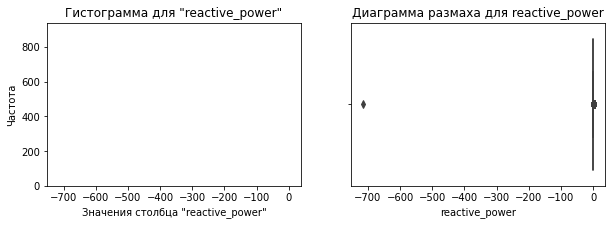

In [23]:
#построение
for name in arc_new_num:
    boxplot_hist(data_arc_new, name)

По признаку active_power можем наблюдать небольшое смещение влево по графику. Среднее значение 0.662752
По признаку reactive_power по графику виден выброс по признаку reactive_power.


In [24]:
#посмотрим на строки с болшим отклонением
data_arc_new[data_arc_new['reactive_power'] < 0]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [25]:
#удалим из датасета эту партию
data_arc_new = data_arc_new[data_arc_new['key'] != 2116]

Посчитаем полную мощность. Складывается из корня кваратов активной и реактивной мощностей

In [26]:
data_arc_new['all_power'] = ((data_arc_new['active_power'])**2 + (data_arc_new['reactive_power'])**2)**0.5

In [27]:
data_arc_new

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,all_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,0.532085
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,0.792429
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,1.293389
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,0.641792


Технически время начала и время конца нагрева как признак не нужен, но длительность процесса будет может повлиять на целевую.

In [28]:
data_arc_new['time_heating'] = data_arc_new['end_arc_heating'] - data_arc_new['start_arc_heating']

In [29]:
data_arc_new['time_heating'] = data_arc_new['time_heating'].dt.total_seconds()

In [30]:
data_arc_new.head(10)

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,all_power,time_heating
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148.0
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,0.440239,137.0
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,0.332731,338.0
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,0.860064,126.0
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,0.955315,210.0
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,1.373863,280.0


Сгруппируем данные по партиям, суммируя длительность и полную мощность

In [31]:
df_arc_heating = data_arc_new.groupby('key')['all_power', 'time_heating'].sum().reset_index()
df_arc_heating

/tmp/ipykernel_48/4189798746.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_arc_heating = data_arc_new.groupby('key')['all_power', 'time_heating'].sum().reset_index()


,key,all_power,time_heating
0,1,3.718736,1098.0
1,2,2.588349,811.0
2,3,5.019223,655.0
3,4,3.400038,741.0
4,5,2.816980,869.0
...,...,...,...
3208,3237,3.250657,909.0
3209,3238,1.723937,546.0
3210,3239,6.014480,1216.0
3211,3240,4.082920,839.0


Посмотрим, что получилось

In [32]:
df_arc_heating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3213 non-null   int64  
 1   all_power     3213 non-null   float64
 2   time_heating  3213 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 75.4 KB


In [33]:
df_arc_heating.describe()

,key,all_power,time_heating
count,3213.000000,3213.000000,3213.000000
mean,1622.907874,3.811201,794.691566
std,934.844882,1.502848,332.439136
min,1.000000,0.331897,57.000000
25%,817.000000,2.775577,571.000000
50%,1623.000000,3.694535,770.000000
75%,2432.000000,4.697427,983.000000
max,3241.000000,15.288271,4189.000000


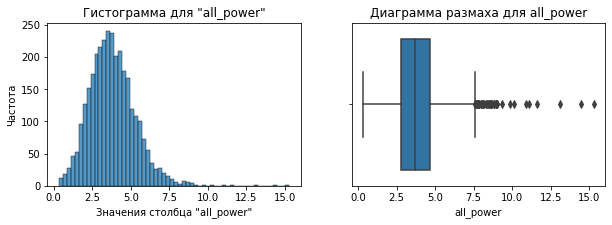

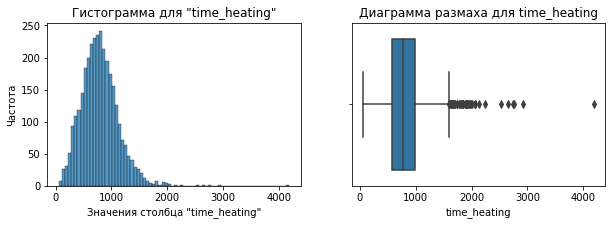

In [34]:
arc_heating_num = ['all_power', 'time_heating']

#построение
for name in arc_heating_num:
    boxplot_hist(df_arc_heating, name)

По графикам можно заметить выбросы, не критичны, поэтому оставим. Распределение в основном ближе к нормальному. 

In [35]:
df_arc_heating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3213 non-null   int64  
 1   all_power     3213 non-null   float64
 2   time_heating  3213 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 75.4 KB


### data_bulk_new

Для начала отредактируем наименование колонок

In [36]:
#заменим наименования колонок
data_bulk_new = data_bulk_new.rename(columns={'Bulk 1' : 'bulk_1',
                                            'Bulk 2' : 'bulk_2',
                                            'Bulk 3' : 'bulk_3',
                                            'Bulk 4' : 'bulk_4',
                                             'Bulk 5' : 'bulk_5',
                                             'Bulk 6' : 'bulk_6',
                                             'Bulk 7' : 'bulk_7',
                                             'Bulk 8' : 'bulk_8',
                                             'Bulk 9' : 'bulk_9',
                                             'Bulk 10' : 'bulk_10',
                                             'Bulk 11' : 'bulk_11',
                                             'Bulk 12' : 'bulk_12',
                                             'Bulk 13' : 'bulk_13',
                                             'Bulk 14' : 'bulk_14',
                                             'Bulk 15' : 'bulk_15'})
#проверим
data_bulk_new.head(10)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [37]:
#исправим пропуски, заменив их на "0"
data_bulk_new = data_bulk_new.fillna(0)
#проверим
data_bulk_new.isna().sum()

key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

In [38]:
data_bulk_new.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


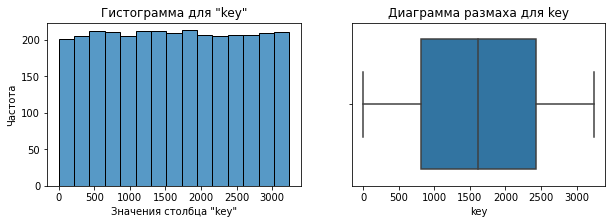

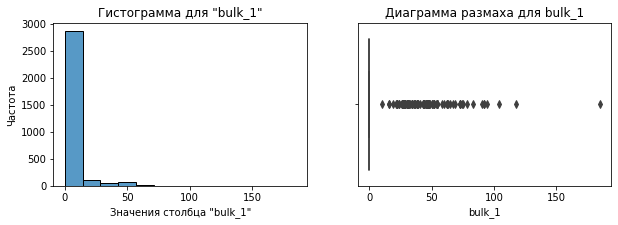

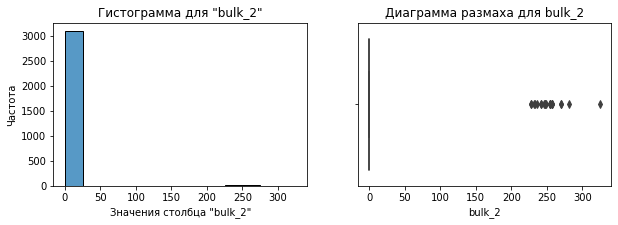

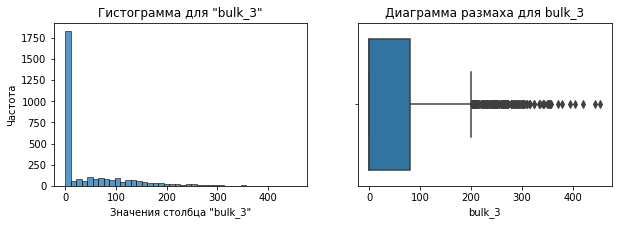

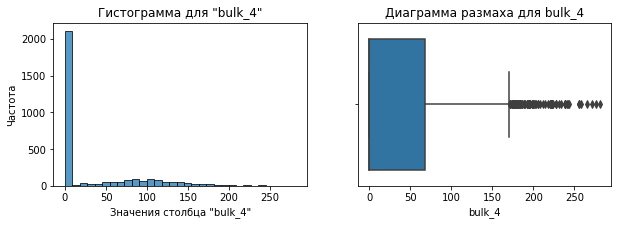

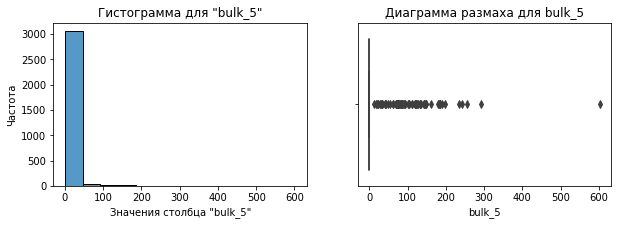

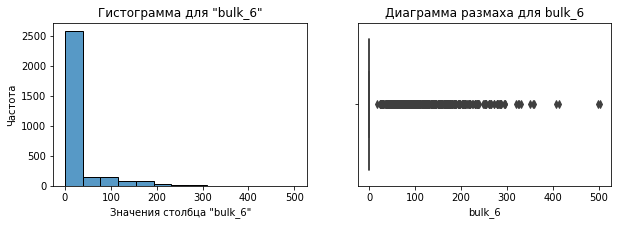

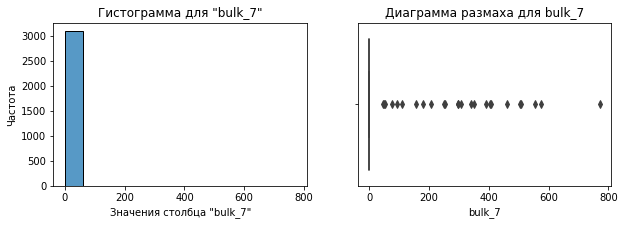

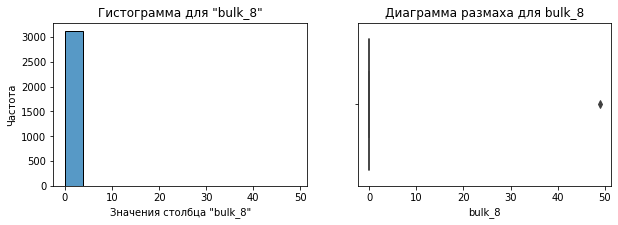

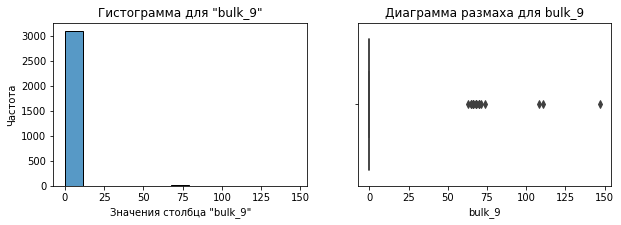

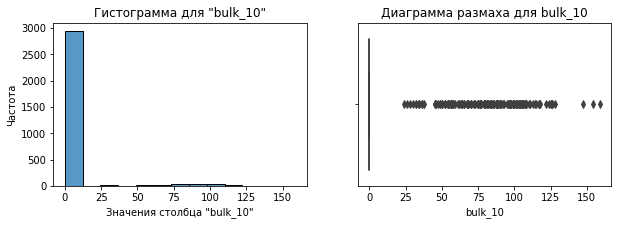

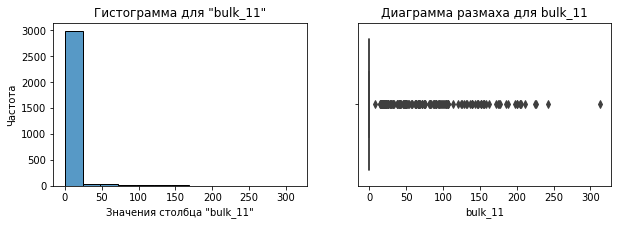

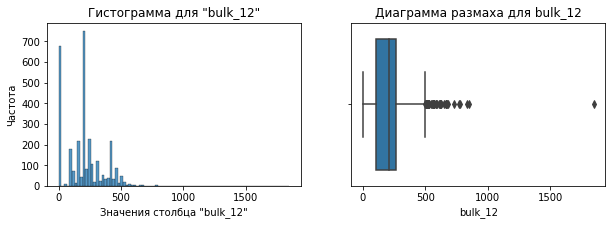

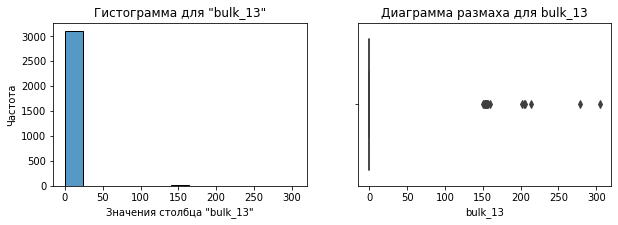

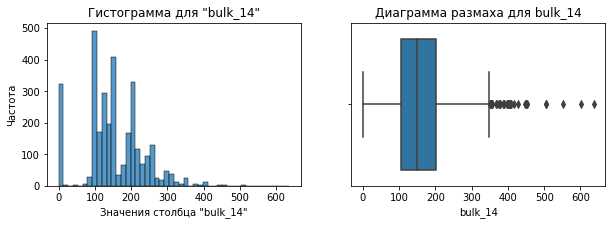

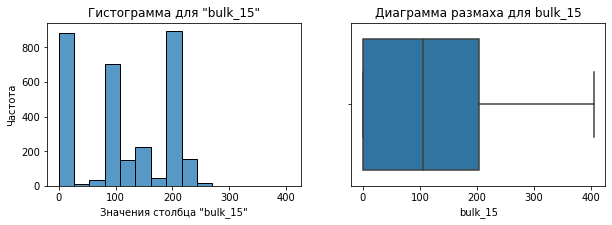

In [39]:
for name in data_bulk_new.columns:
    boxplot_hist(data_bulk_new, name)

In [40]:
data_bulk_new['bulk_rare'] = data_bulk_new['bulk_1'] + data_bulk_new['bulk_2'] + data_bulk_new['bulk_5'] + data_bulk_new['bulk_7'] + data_bulk_new['bulk_8'] + data_bulk_new['bulk_9'] + data_bulk_new['bulk_10'] + data_bulk_new['bulk_11'] + data_bulk_new['bulk_13']
data_bulk_new

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_rare
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,0.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,0.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,0.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,0.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,0.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,0.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,0.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,0.0


In [41]:
data_bulk_new.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_rare
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271,20.565996
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698,72.177461
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000,0.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000,0.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,1187.000000


### data_gas_new

In [42]:
data_gas_new

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [43]:
data_gas_new = data_gas_new.rename(columns={'Газ 1' : 'gas_1'})
data_gas_new.head(1)

,key,gas_1
0,1,29.749986


In [44]:
data_gas_new.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


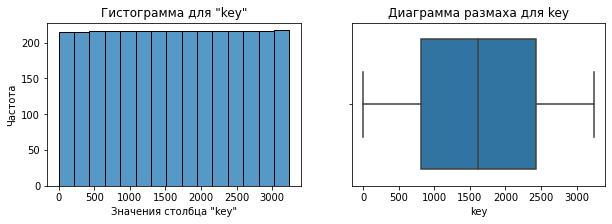

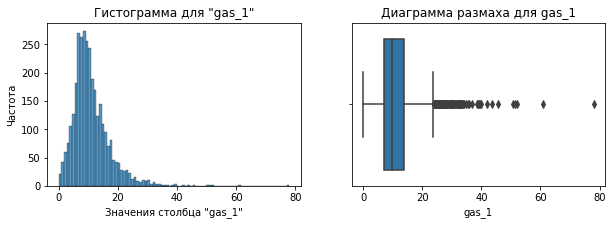

In [45]:
for name in data_gas_new.columns:
    boxplot_hist(data_gas_new, name)

По результату имеем гистограмму с близким к нормальному распределению, имеется 2 небольших пика. В основном диапозон значений от 6 до 13. Среднее 10.63.

### data_temp_new

In [46]:
data_temp_new.head(5)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [47]:
#заменим наименования колонок
data_temp_new = data_temp_new.rename(columns={'Время замера' : 'time_measurement',
                                            'Температура' : 'temp'})
#проверим
data_temp_new.head(1)

,key,time_measurement,temp
0,1,2019-05-03 11:02:04,1571.0


In [48]:
#изменим тип данных
data_temp_new['time_measurement'] = pd.to_datetime(data_temp_new['time_measurement'])
data_temp_new.dtypes

key                          int64
time_measurement    datetime64[ns]
temp                       float64
dtype: object

Сгруппируем данные по партии, и запишем в отдельные столбцы время начала процесса партии и температуру, и окончание процесса и температуру на выходе

In [49]:
df_temp_in = data_temp_new.loc[data_temp_new.groupby(['key'])['time_measurement'].idxmin()]

In [50]:
df_temp_out = data_temp_new.loc[data_temp_new.groupby(['key'])['time_measurement'].idxmax()]

In [51]:
df_temp = pd.merge(df_temp_in, df_temp_out, on='key')

In [52]:
df_temp

,key,time_measurement_x,temp_x,time_measurement_y,temp_y
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...,...
3211,3237,2019-09-06 11:31:15,1569.0,2019-09-06 11:55:45,NaN
3212,3238,2019-09-06 12:16:15,1584.0,2019-09-06 12:34:37,NaN
3213,3239,2019-09-06 14:16:50,1598.0,2019-09-06 15:09:55,NaN
3214,3240,2019-09-06 15:25:21,1617.0,2019-09-06 16:35:26,NaN


In [53]:
#заменим наименования колонок
df_temp = df_temp.rename(columns={'time_measurement_x' : 'time_in',
                                  'temp_x' : 'temp_in',
                                  'time_measurement_y' : 'time_out',
                                 'temp_y' : 'temp_out'})
#проверим
df_temp.head(1)

,key,time_in,temp_in,time_out,temp_out
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0


In [54]:
df_temp.describe()

,key,temp_in,temp_out
count,3216.000000,3216.000000,2477.000000
mean,1622.199316,1588.592040,1595.334275
std,935.088523,29.137454,16.019339
min,1.000000,1191.000000,1541.000000
25%,815.750000,1572.000000,1587.000000
50%,1622.500000,1588.000000,1593.000000
75%,2431.250000,1606.000000,1599.000000
max,3241.000000,1684.000000,1700.000000


In [55]:
df_temp.isna().sum()

key           0
time_in       0
temp_in       0
time_out      0
temp_out    739
dtype: int64

In [56]:
df_temp[df_temp['temp_out'].isna()]

,key,time_in,temp_in,time_out,temp_out
2477,2500,2019-08-10 14:04:39,1539.0,2019-08-10 14:29:39,NaN
2478,2501,2019-08-10 14:41:14,1587.0,2019-08-10 15:29:00,NaN
2479,2502,2019-08-10 15:39:39,1583.0,2019-08-10 16:04:55,NaN
2480,2503,2019-08-10 16:27:44,1603.0,2019-08-10 17:14:24,NaN
2481,2504,2019-08-10 17:31:43,1583.0,2019-08-10 18:03:42,NaN
...,...,...,...,...,...
3211,3237,2019-09-06 11:31:15,1569.0,2019-09-06 11:55:45,NaN
3212,3238,2019-09-06 12:16:15,1584.0,2019-09-06 12:34:37,NaN
3213,3239,2019-09-06 14:16:50,1598.0,2019-09-06 15:09:55,NaN
3214,3240,2019-09-06 15:25:21,1617.0,2019-09-06 16:35:26,NaN


In [57]:
df_temp = df_temp.dropna()

In [58]:
df_temp.isnull().sum()

key         0
time_in     0
temp_in     0
time_out    0
temp_out    0
dtype: int64

In [59]:
df_temp.describe()

,key,temp_in,temp_out
count,2477.000000,2477.000000,2477.000000
mean,1249.968510,1588.405733,1595.334275
std,720.073717,29.232904,16.019339
min,1.000000,1191.000000,1541.000000
25%,628.000000,1572.000000,1587.000000
50%,1251.000000,1588.000000,1593.000000
75%,1872.000000,1605.000000,1599.000000
max,2499.000000,1679.000000,1700.000000


В датасете имеем температуры мин 1191 градус, при услови, что температура плавления стали выше 1400 градусов, то отфильтруем и уберем из датасета непригодные партии

In [60]:
df_temp[df_temp['temp_in'] < 1400]

,key,time_in,temp_in,time_out,temp_out
855,867,2019-06-06 08:03:39,1191.0,2019-06-06 08:48:23,1599.0
1201,1214,2019-06-18 08:01:03,1208.0,2019-06-18 08:43:56,1591.0
1604,1619,2019-07-03 02:34:41,1218.0,2019-07-03 02:43:59,1590.0
2036,2052,2019-07-25 08:49:15,1227.0,2019-07-25 09:27:03,1592.0


In [61]:
df_temp = df_temp[df_temp['key'] != 867]
df_temp = df_temp[df_temp['key'] != 1214]
df_temp = df_temp[df_temp['key'] != 1619]
df_temp = df_temp[df_temp['key'] != 2052]

In [62]:
df_temp[df_temp['temp_in'] < 1400]

,key,time_in,temp_in,time_out,temp_out


Вычислим продолжительность процесса каждой партии

In [63]:
delta = df_temp['time_out'] - df_temp['time_in']

In [64]:
df_temp['all_time'] = delta.dt.total_seconds()

In [65]:
df_temp

,key,time_in,temp_in,time_out,temp_out,all_time
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,1714.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,1265.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,1753.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,1220.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,1536.0
...,...,...,...,...,...,...
2472,2495,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47,1591.0,1380.0
2473,2496,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13,1591.0,1705.0
2474,2497,2019-08-10 12:37:26,1571.0,2019-08-10 12:53:28,1589.0,962.0
2475,2498,2019-08-10 12:58:11,1591.0,2019-08-10 13:23:31,1594.0,1520.0


In [66]:
df_temp.describe()

,key,temp_in,temp_out,all_time
count,2473.000000,2473.000000,2473.000000,2473.000000
mean,1249.664375,1589.016175,1595.338051,2279.472705
std,720.395663,24.996127,16.031388,1375.318051
min,1.000000,1519.000000,1541.000000,0.000000
25%,627.000000,1572.000000,1587.000000,1541.000000
50%,1251.000000,1588.000000,1593.000000,2007.000000
75%,1872.000000,1605.000000,1599.000000,2739.000000
max,2499.000000,1679.000000,1700.000000,23674.000000


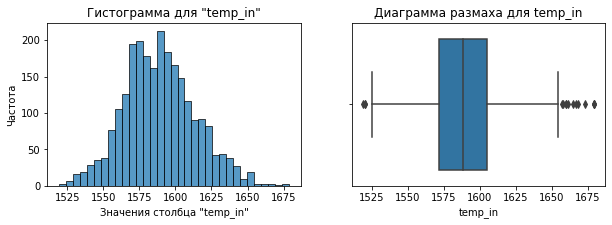

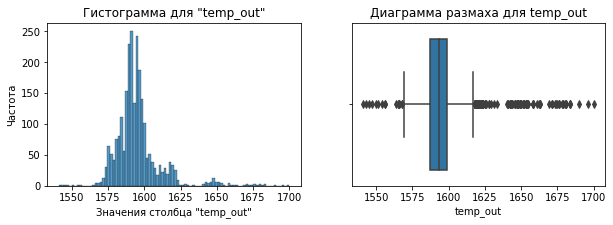

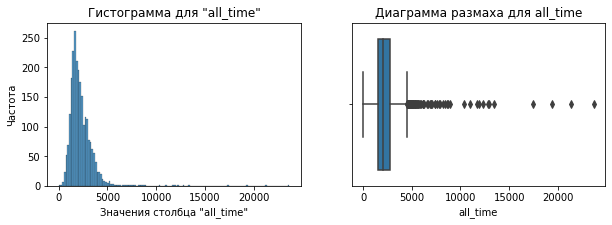

In [67]:
data_temp_num = ['temp_in', 'temp_out', 'all_time']

for name in data_temp_num:
    boxplot_hist(df_temp, name)

По графикоам можем заметить выбросы, не критично, оставим.

### data_wire_new

In [68]:
#заменим наименования колонок
data_wire_new = data_wire_new.rename(columns={'Wire 1' : 'wire_1',
                                            'Wire 2' : 'wire_2',
                                            'Wire 3' : 'wire_3',
                                            'Wire 4' : 'wire_4',
                                             'Wire 5' : 'wire_5',
                                             'Wire 6' : 'wire_6',
                                             'Wire 7' : 'wire_7',
                                             'Wire 8' : 'wire_8',
                                             'Wire 9' : 'wire_9'})
#проверим
data_wire_new.head(1)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Так же заменим все пропуски на 0

In [69]:
#исправим пропуски, заменив их на "0"
data_wire_new = data_wire_new.fillna(0)
#проверим
data_wire_new.isna().sum()

key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

In [70]:
data_wire_new.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


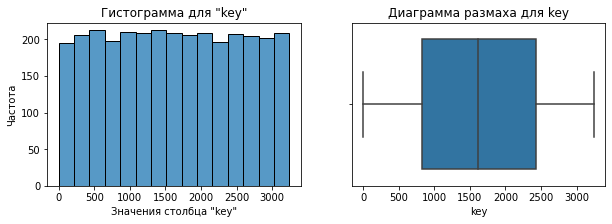

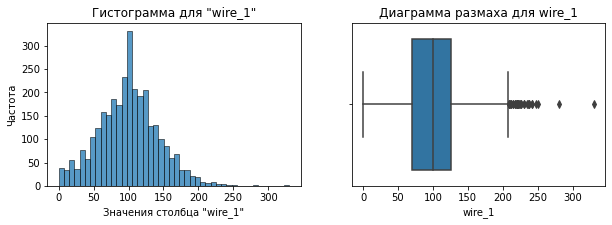

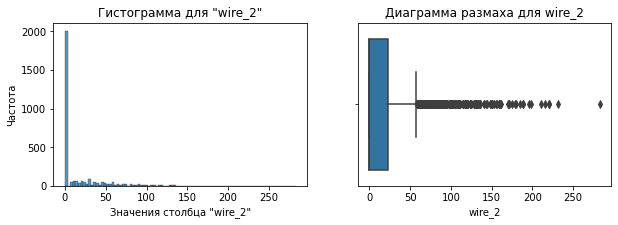

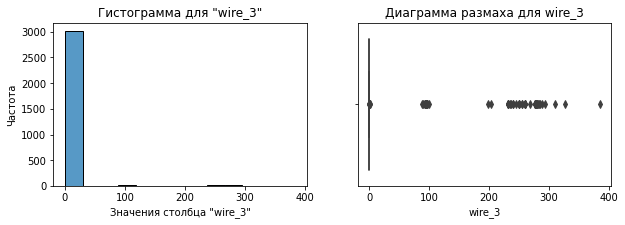

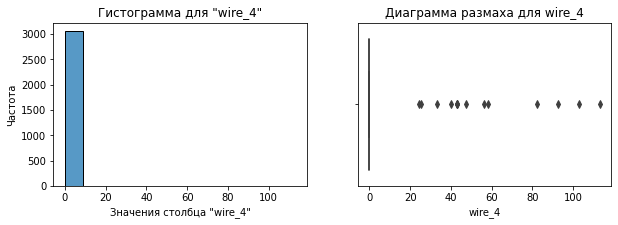

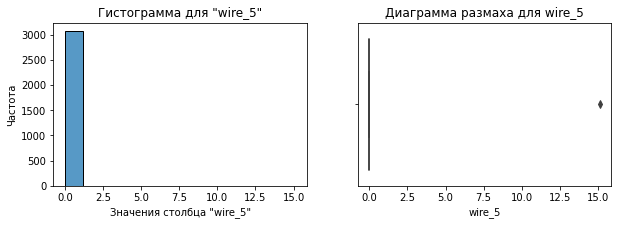

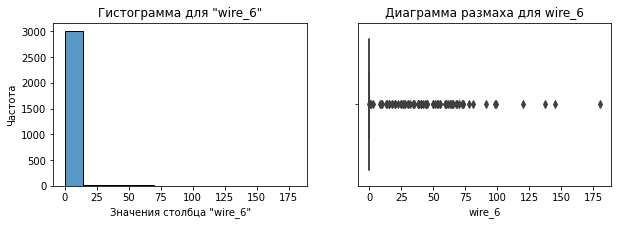

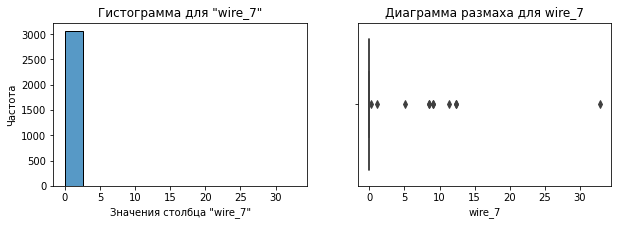

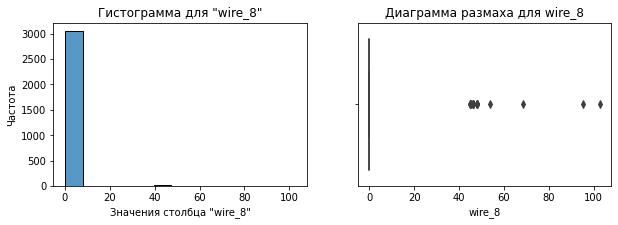

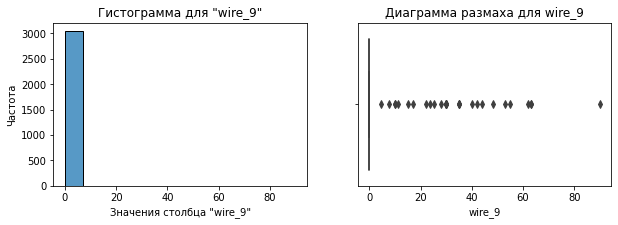

In [71]:
for name in data_wire_new.columns:
    boxplot_hist(data_wire_new, name)

In [72]:

data_wire_new['wire_rare'] = data_wire_new['wire_4'] + data_wire_new['wire_5'] + data_wire_new['wire_6'] + data_wire_new['wire_7'] + data_wire_new['wire_8'] + data_wire_new['wire_9']


In [73]:
data_wire_new.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_rare
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492,2.091657
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904,12.911249
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604,189.859800


## Объединение данных

Произведем объеденение датасетов по ключу(партиям)

In [74]:
df_all = pd.merge(df_temp, df_arc_heating, on='key')

In [75]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2470 entries, 0 to 2469
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           2470 non-null   int64         
 1   time_in       2470 non-null   datetime64[ns]
 2   temp_in       2470 non-null   float64       
 3   time_out      2470 non-null   datetime64[ns]
 4   temp_out      2470 non-null   float64       
 5   all_time      2470 non-null   float64       
 6   all_power     2470 non-null   float64       
 7   time_heating  2470 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(1)
memory usage: 173.7 KB


In [76]:
df_all = df_all.merge(data_bulk_new, on='key')

In [77]:
df_all = df_all.merge(data_gas_new, on='key')

In [78]:
df_all = df_all.merge(data_wire_new, on='key')

In [79]:
df_all.columns

Index(['key', 'time_in', 'temp_in', 'time_out', 'temp_out', 'all_time',
       'all_power', 'time_heating', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4',
       'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11',
       'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'bulk_rare', 'gas_1',
       'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7',
       'wire_8', 'wire_9', 'wire_rare'],
      dtype='object')

In [80]:
drop_columns = ['bulk_1', 'bulk_2',
                'bulk_5', 'bulk_7',
                'bulk_8', 'bulk_9',
                'bulk_10', 'bulk_11',
                'bulk_13', 'time_in',
                'time_out', 'wire_4',
                'wire_5', 'wire_6',
                'wire_7', 'wire_8',
                'wire_9']

In [81]:
df_all = df_all.drop(['bulk_1', 'bulk_2', 
                'bulk_5', 'bulk_7',
                'bulk_8', 'bulk_9',
                'bulk_10', 'bulk_11',
                'bulk_13', 'time_in',
                'time_out', 'wire_4',
                'wire_5', 'wire_6',
                'wire_7', 'wire_8',
                'wire_9'], axis=1)

Проверим полученный датасет

In [82]:
inspection(df_all)

,key,temp_in,temp_out,all_time,all_power,time_heating,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,bulk_rare,gas_1,wire_1,wire_2,wire_3,wire_rare
0,1,1571.0,1613.0,1714.0,3.718736,1098.0,0.0,43.0,0.0,206.0,150.0,154.0,0.0,29.749986,60.059998,0.00000,0.0,0.0
1,2,1581.0,1602.0,1265.0,2.588349,811.0,0.0,73.0,0.0,206.0,149.0,154.0,0.0,12.555561,96.052315,0.00000,0.0,0.0
2,3,1596.0,1599.0,1753.0,5.019223,655.0,0.0,34.0,0.0,205.0,152.0,153.0,0.0,28.554793,91.160157,0.00000,0.0,0.0
3,4,1601.0,1625.0,1220.0,3.400038,741.0,0.0,81.0,0.0,207.0,153.0,154.0,0.0,18.841219,89.063515,0.00000,0.0,0.0
4,5,1576.0,1602.0,1536.0,2.816980,869.0,0.0,78.0,0.0,203.0,151.0,152.0,0.0,5.413692,89.238236,9.11456,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2495,1570.0,1591.0,1380.0,3.868721,723.0,21.0,0.0,0.0,256.0,129.0,223.0,90.0,7.125735,89.150879,0.00000,0.0,0.0
2320,2496,1554.0,1591.0,1705.0,5.070316,940.0,0.0,63.0,0.0,256.0,129.0,226.0,122.0,9.412616,114.179527,0.00000,0.0,0.0
2321,2497,1571.0,1589.0,962.0,4.360918,569.0,0.0,85.0,0.0,230.0,124.0,226.0,0.0,6.271699,94.086723,9.04800,0.0,0.0
2322,2498,1591.0,1594.0,1520.0,3.909917,750.0,90.0,0.0,0.0,206.0,129.0,207.0,101.0,14.953657,118.110717,0.00000,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2324 non-null   int64  
 1   temp_in       2324 non-null   float64
 2   temp_out      2324 non-null   float64
 3   all_time      2324 non-null   float64
 4   all_power     2324 non-null   float64
 5   time_heating  2324 non-null   float64
 6   bulk_3        2324 non-null   float64
 7   bulk_4        2324 non-null   float64
 8   bulk_6        2324 non-null   float64
 9   bulk_12       2324 non-null   float64
 10  bulk_14       2324 non-null   float64
 11  bulk_15       2324 non-null   float64
 12  bulk_rare     2324 non-null   float64
 13  gas_1         2324 non-null   float64
 14  wire_1        2324 non-null   float64
 15  wire_2        2324 non-null   float64
 16  wire_3        2324 non-null   float64
 17  wire_rare     2324 non-null   float64
dtypes: float64(17), int64(1)
mem

(None, None, None, None)

В резльутате получили датасет на 18 колонок, и 2228 строк, т.е. партий.
Пропусков нет, дубликатов нет.

## Исследовательский анализ и предобработка данных объединённого датафрейма

In [83]:
df_all.describe()

,key,temp_in,temp_out,all_time,all_power,time_heating,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,bulk_rare,gas_1,wire_1,wire_2,wire_3,wire_rare
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,1251.140275,1587.368761,1593.372633,2323.682014,3.886143,808.196644,47.317126,37.347676,22.419535,208.597676,153.952668,120.078313,20.370052,11.378854,102.423900,17.613213,3.241876,1.924286
std,715.027927,23.627590,11.207457,1385.809791,1.517584,340.813828,75.238050,58.677890,55.792509,157.112117,81.410544,84.655967,69.082754,6.397008,43.540975,33.648176,27.972523,12.933152
min,1.000000,1519.000000,1541.000000,339.000000,0.331897,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,0.000000,0.000000,0.000000,0.000000
25%,628.750000,1571.000000,1587.000000,1580.500000,2.846893,581.000000,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,0.000000,7.282534,73.204559,0.000000,0.000000,0.000000
50%,1254.500000,1587.000000,1593.000000,2046.500000,3.770584,778.000000,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,0.000000,10.100687,101.103600,0.000000,0.000000,0.000000
75%,1867.250000,1603.000000,1598.000000,2793.500000,4.769753,993.000000,80.000000,77.250000,0.000000,283.000000,204.000000,204.000000,0.000000,14.218487,128.075222,23.102560,0.000000,0.000000
max,2499.000000,1660.000000,1653.000000,23674.000000,15.288271,4189.000000,454.000000,281.000000,503.000000,1849.000000,636.000000,405.000000,1187.000000,77.995040,330.314424,282.780152,385.008668,189.859800


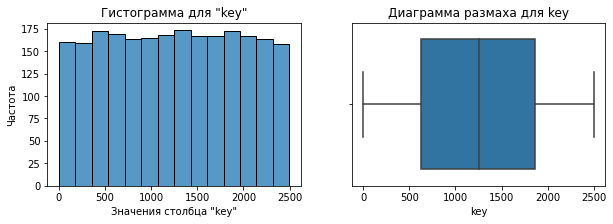

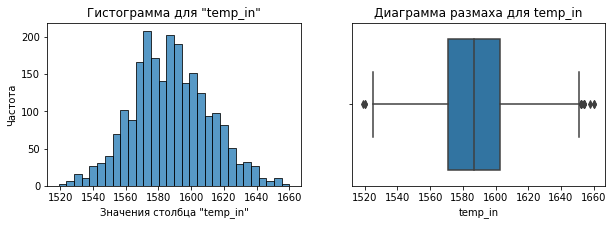

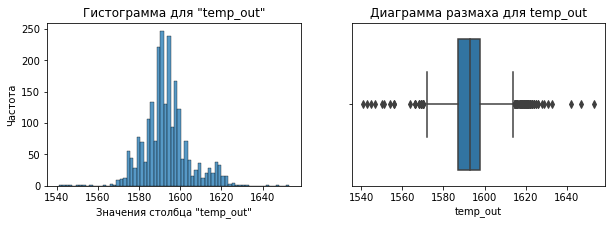

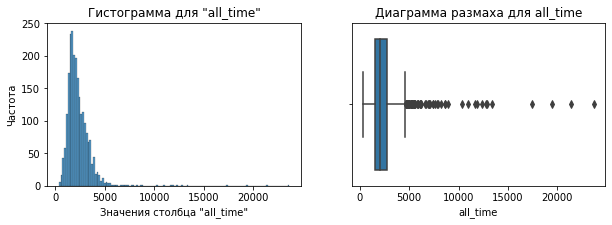

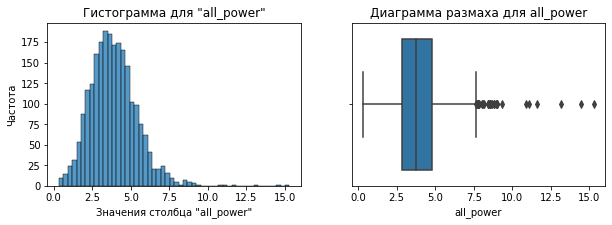

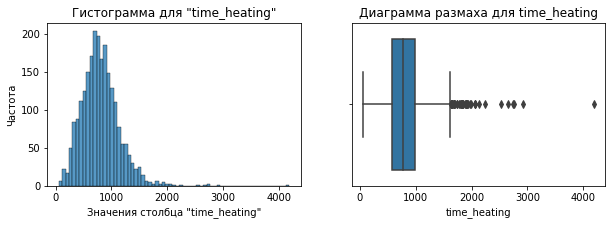

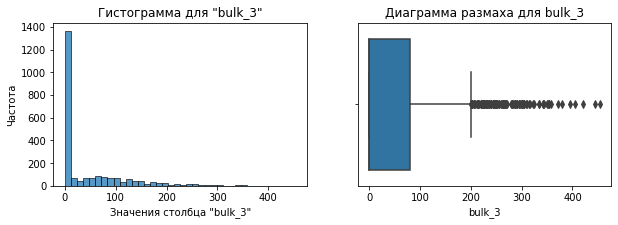

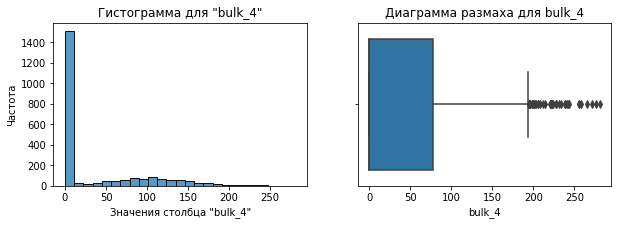

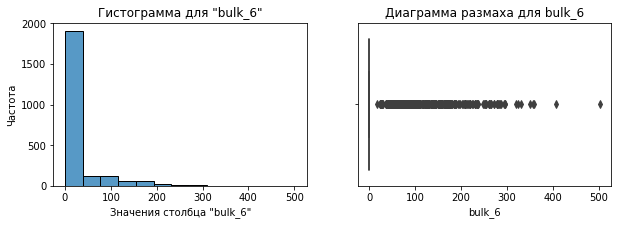

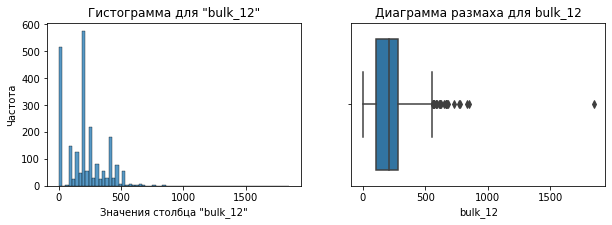

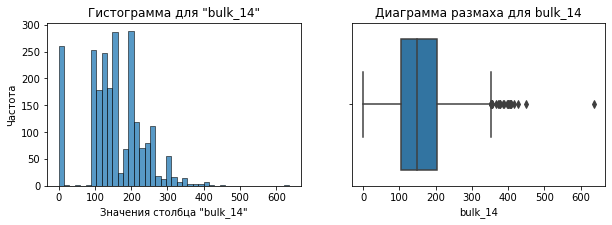

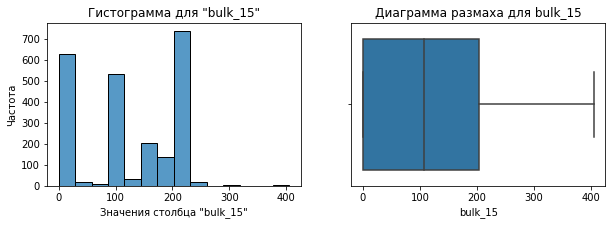

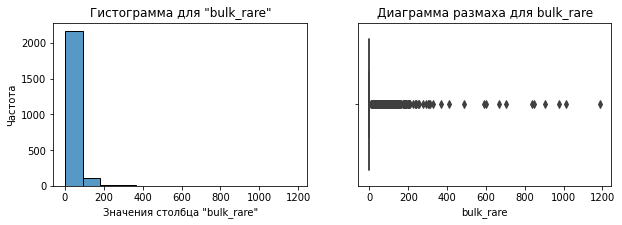

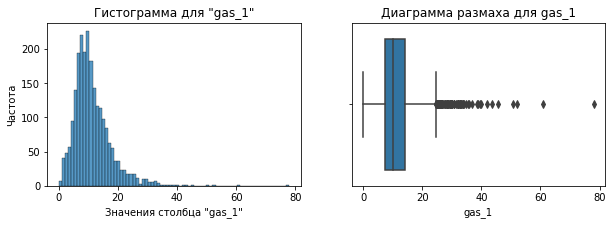

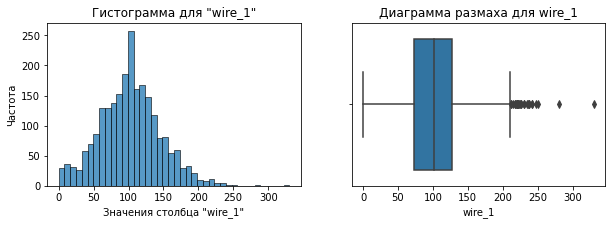

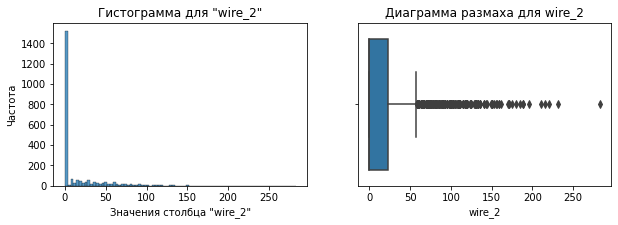

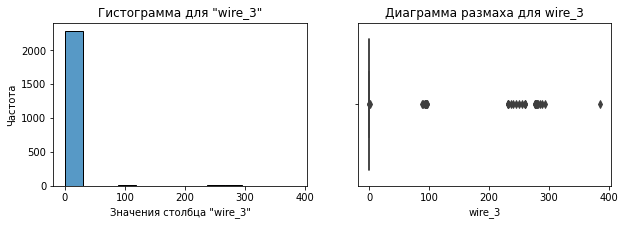

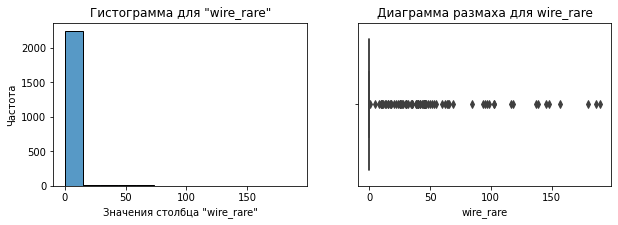

In [84]:
for name in df_all.columns:
    boxplot_hist(df_all, name)

Посмотрим отношение целевого признака, к остальным

Text(0, 0.5, 'Партии')

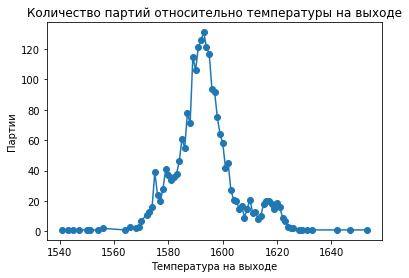

In [85]:
plt.plot(df_all.groupby('temp_out')['key'].count(),marker='o')
plt.title('Количество партий относительно температуры на выходе')
plt.xlabel('Температура на выходе')
plt.ylabel('Партии')


Text(0, 0.5, 'Время процесса')

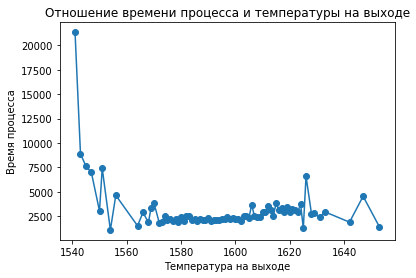

In [86]:
plt.plot(df_all.groupby('temp_out')['all_time'].mean(), marker='o')
plt.title('Отношение времени процесса и температуры на выходе')
plt.xlabel('Температура на выходе')
plt.ylabel('Время процесса')

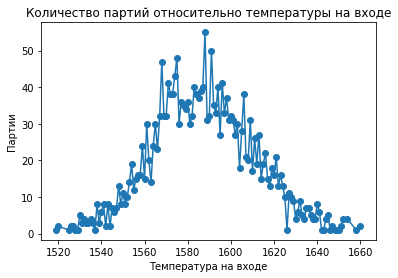

In [87]:
plt.plot(df_all.groupby('temp_in')['key'].count(),marker='o')
plt.title('Количество партий относительно температуры на входе')
plt.xlabel('Температура на входе')
plt.ylabel('Партии')
plt.show()

In [88]:
bulk = [ 'bulk_3', 'bulk_4',
        'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'bulk_rare']

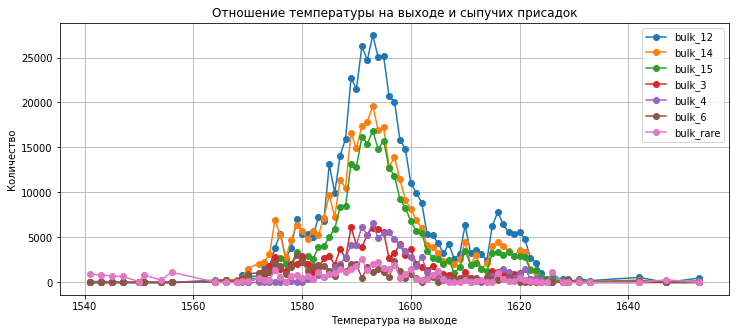

In [89]:
top = df_all.pivot_table(index='temp_out', values=bulk, aggfunc='sum')
top.plot(marker='o', grid=True, figsize=(12, 5))
plt.title('Отношение температуры на выходе и сыпучих присадок')
plt.xlabel('Температура на выходе')
plt.ylabel('Количество')
plt.show()


In [90]:
wire = [ 'wire_1', 'wire_2','wire_3', 'wire_rare']

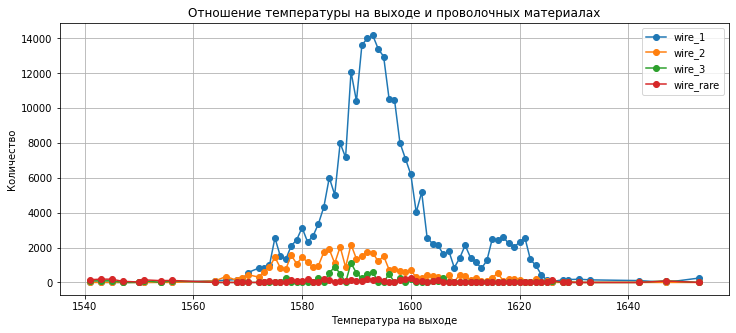

In [91]:
top = df_all.pivot_table(index='temp_out', values=wire, aggfunc='sum')
top.plot(marker='o', grid=True, figsize=(12, 5))
plt.title('Отношение температуры на выходе и проволочных материалах')
plt.xlabel('Температура на выходе')
plt.ylabel('Количество')
plt.show()

Исходя из полученных диаграмм, можем увидеть, что основное количество признаков идет на температуру на выходе около 1590-1600 градусов.

In [92]:
#создадим функцию для постраения диаграмм рассеиния
def scat(df, column):
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=df_all, x="temp_out", y=column, palette='bright')
    plt.xlabel(f'Значения столбца "Итоговая температура"')
    plt.ylabel(f'Диаграмма рассеивания для "{column}"')
    plt.title(f'Диаграмма рассеивания для "{column}"')

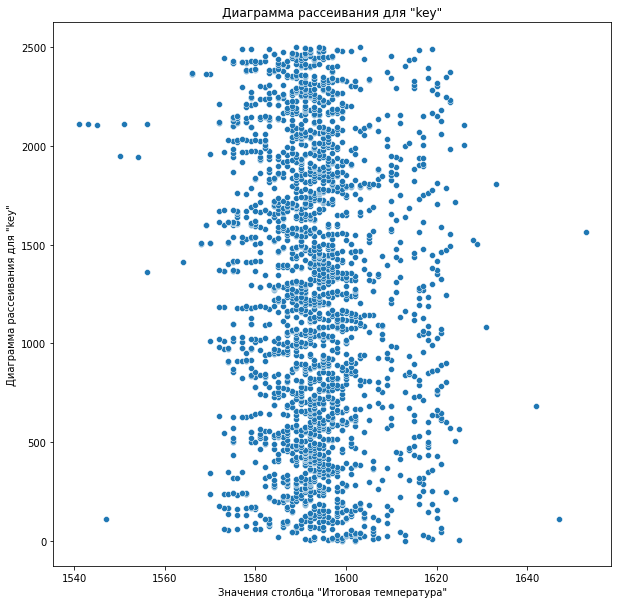

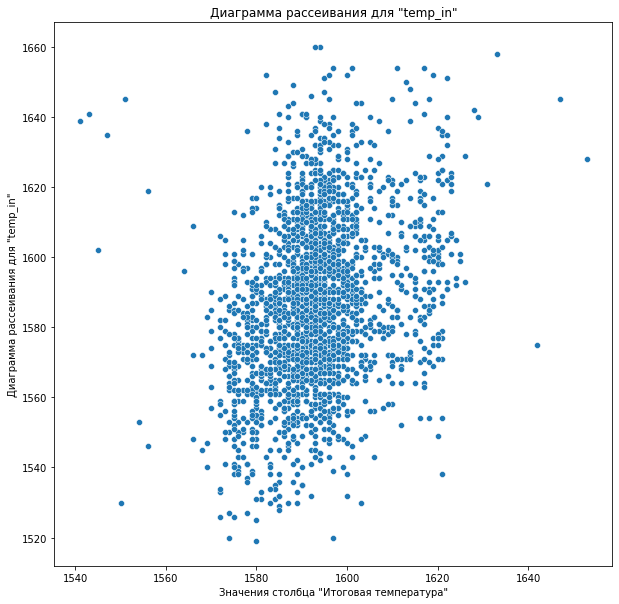

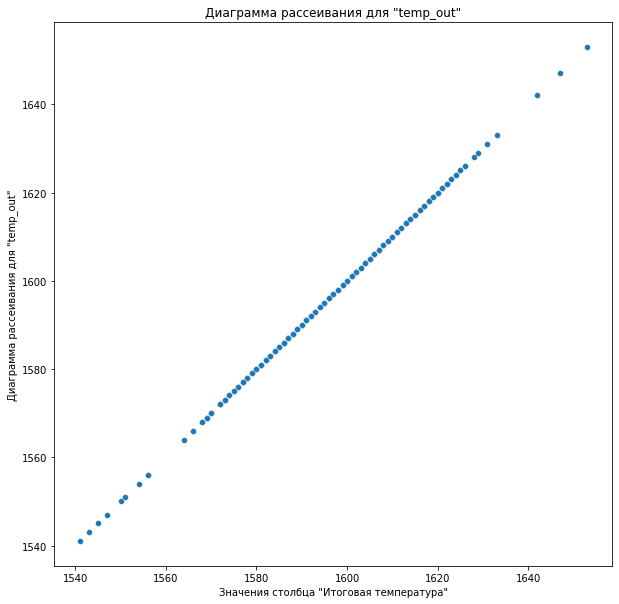

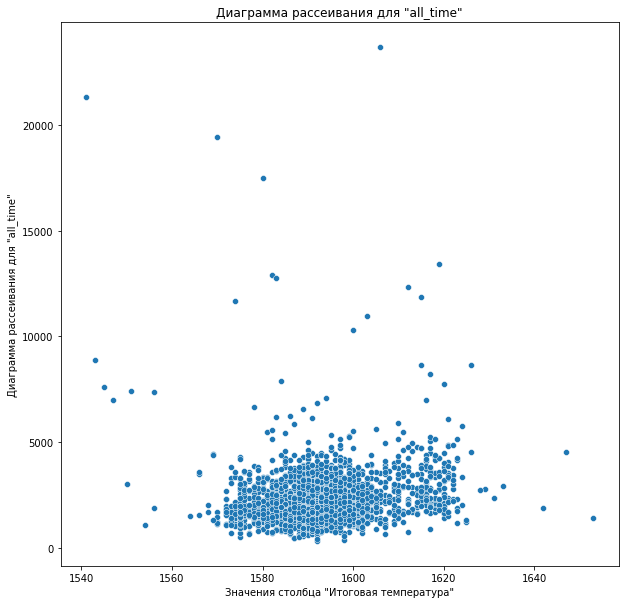

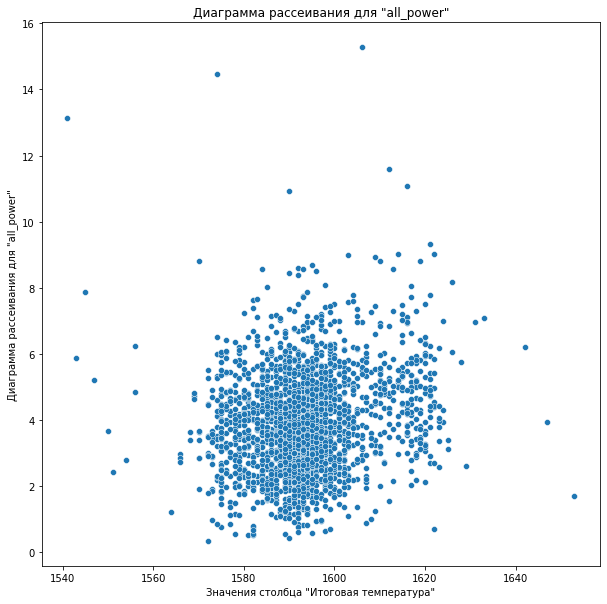

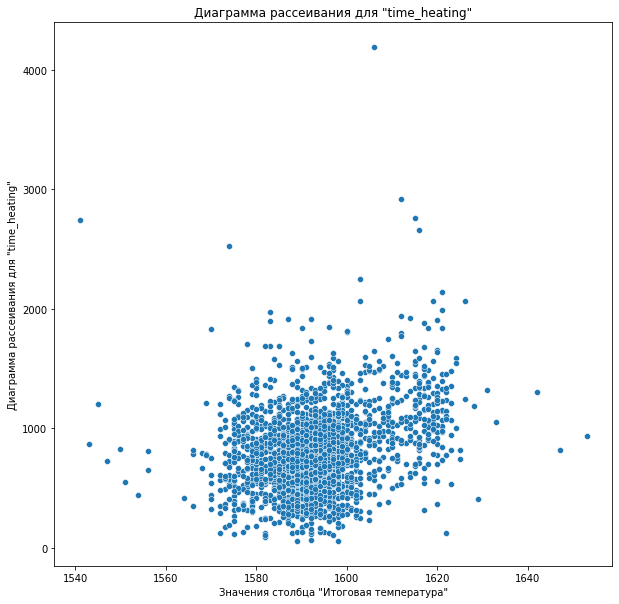

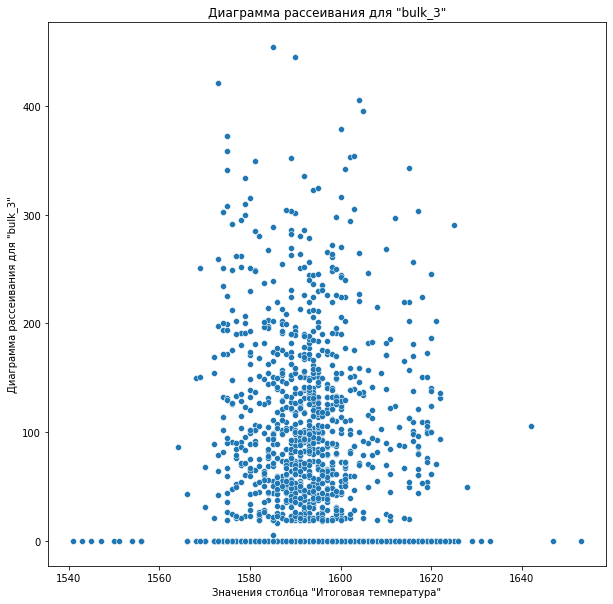

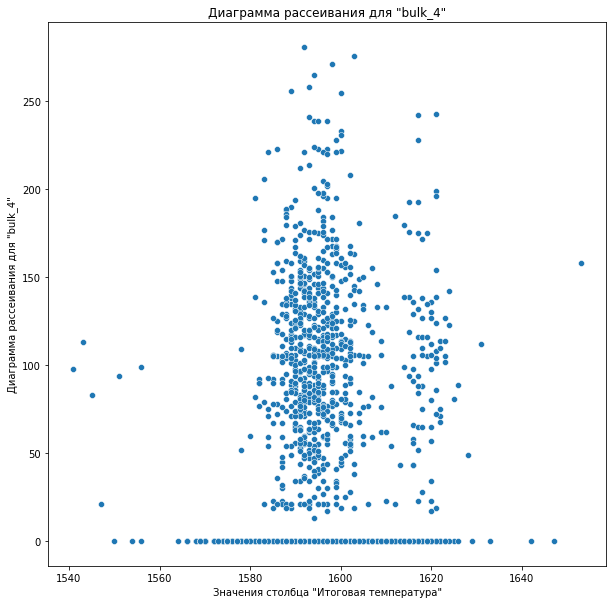

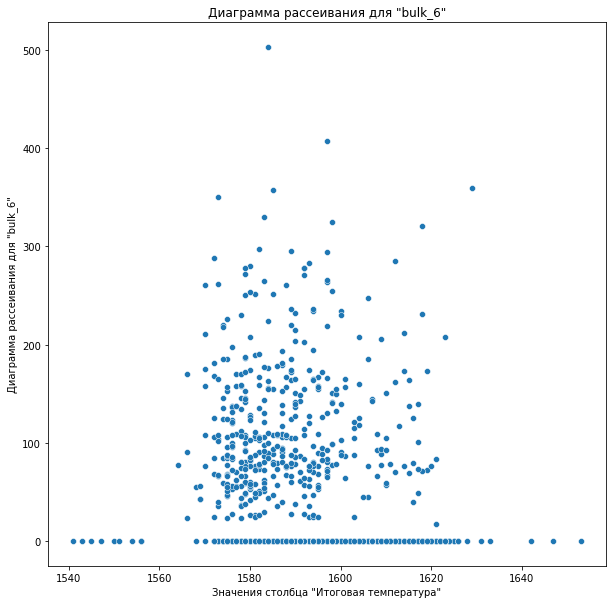

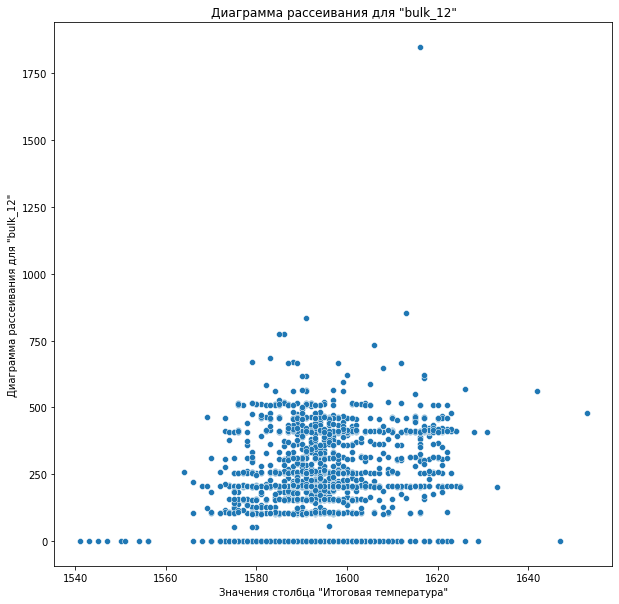

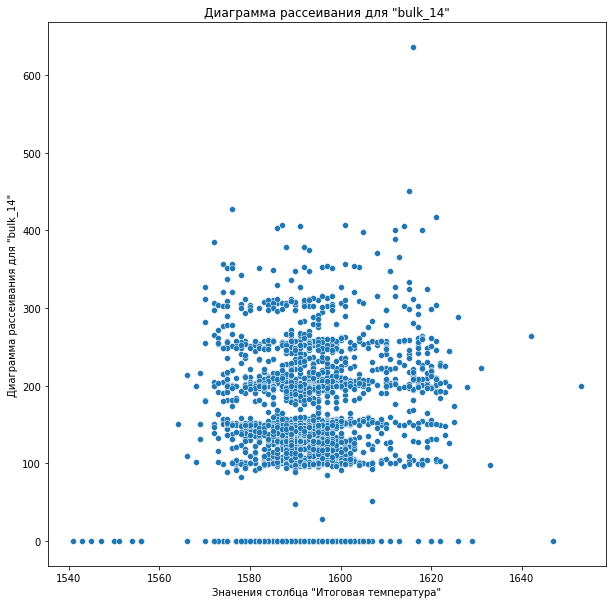

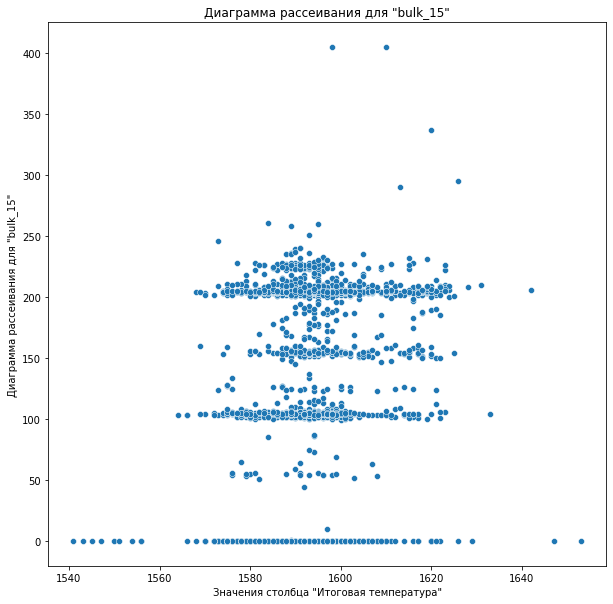

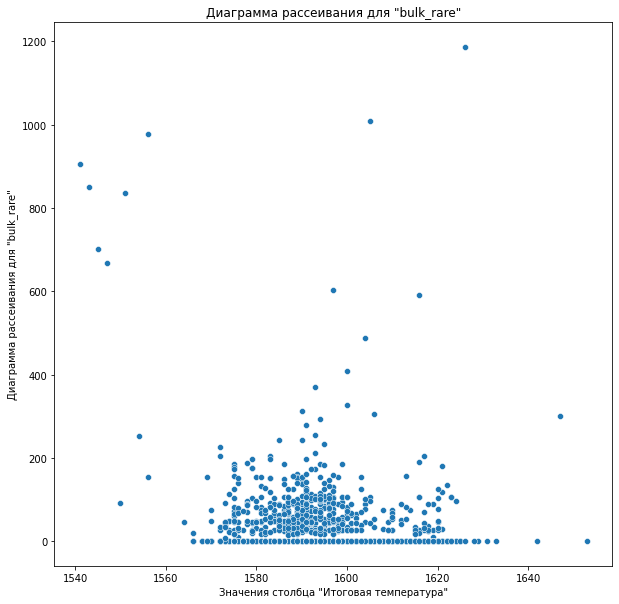

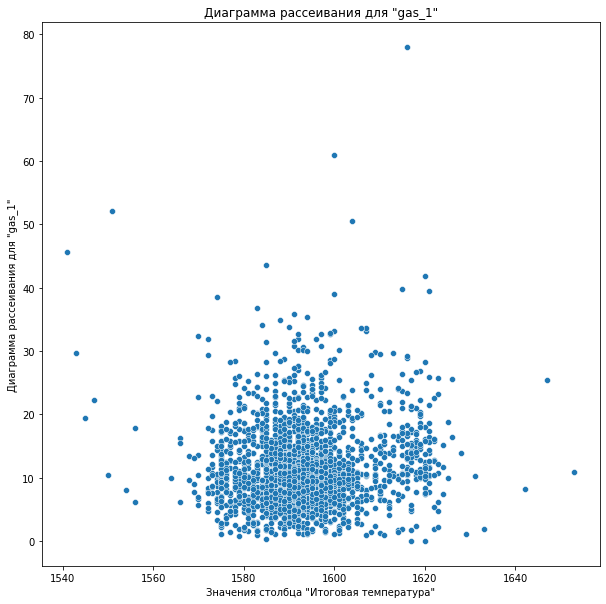

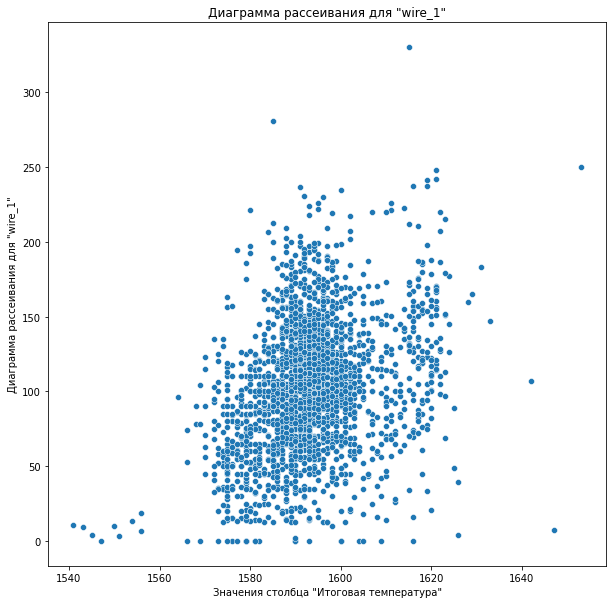

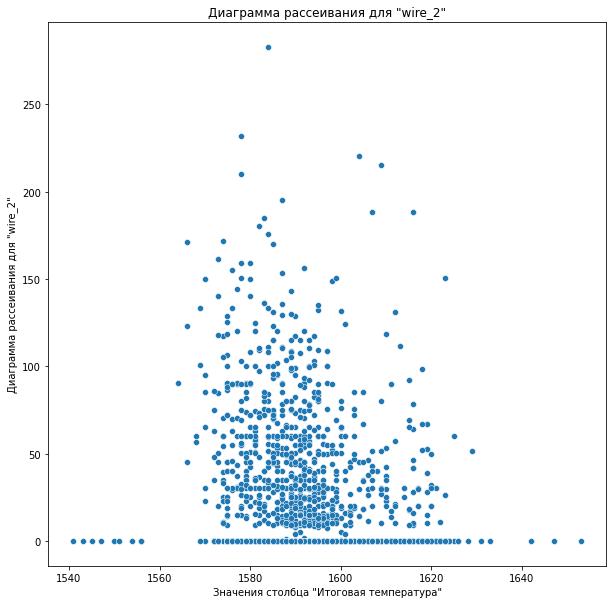

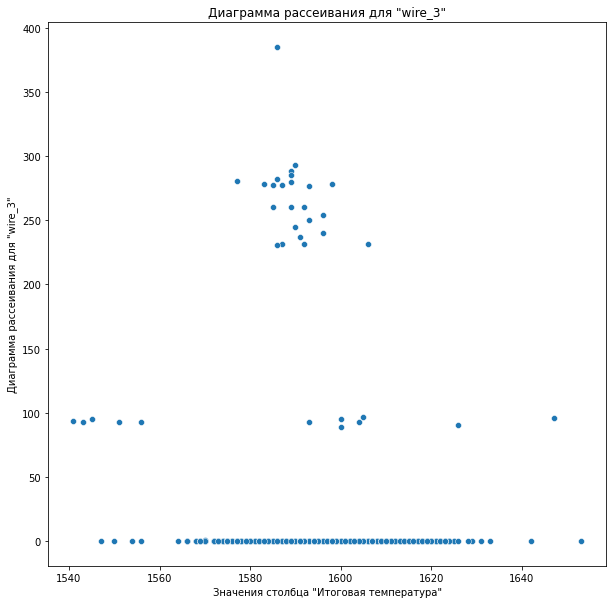

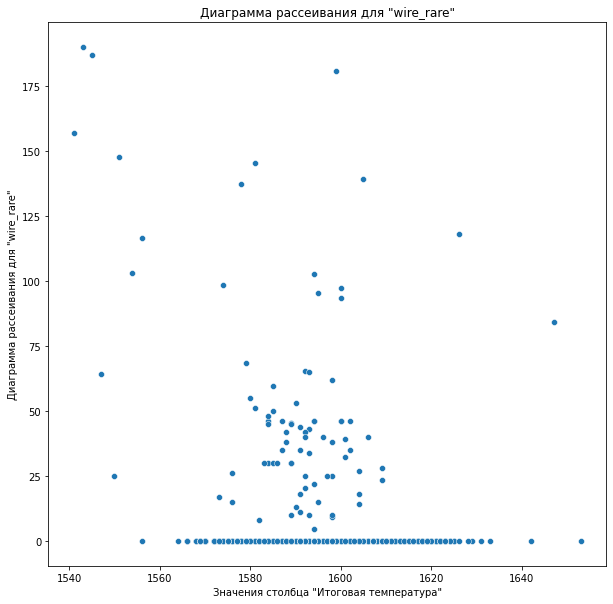

In [93]:
for name in df_all.columns:
    scat(df_all, name)

In [94]:
df_all.corr()

,key,temp_in,temp_out,all_time,all_power,time_heating,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,bulk_rare,gas_1,wire_1,wire_2,wire_3,wire_rare
key,1.000000,-0.016279,-0.096408,-0.019423,-0.021472,-0.028140,-0.006001,-0.026251,0.005363,0.026981,-0.110121,-0.044505,0.043070,-0.043089,-0.013408,0.043647,-0.027178,0.006768
temp_in,-0.016279,1.000000,0.301882,0.210786,-0.152890,-0.383939,-0.113380,0.165484,-0.127046,-0.079574,-0.179991,-0.062382,0.093752,0.036736,0.262880,-0.101101,-0.003403,0.033367
temp_out,-0.096408,0.301882,1.000000,0.096126,0.174833,0.277953,-0.037156,0.187817,-0.180906,0.266805,0.114893,0.265772,-0.116404,0.059079,0.317488,-0.207242,-0.047636,-0.128734
all_time,-0.019423,0.210786,0.096126,1.000000,0.538608,0.562472,0.023019,0.002019,0.154967,0.209555,0.173886,0.099081,0.299016,0.439041,0.154280,0.060407,0.068401,0.193629
all_power,-0.021472,-0.152890,0.174833,0.538608,1.000000,0.719234,0.100677,0.004699,0.133724,0.285529,0.298727,0.168286,0.178564,0.370464,0.138138,0.062337,0.055081,0.081378
time_heating,-0.028140,-0.383939,0.277953,0.562472,0.719234,1.000000,0.091603,-0.029086,0.162777,0.466002,0.461035,0.294538,0.122415,0.396207,0.055443,0.054460,0.033251,0.051889
bulk_3,-0.006001,-0.113380,-0.037156,0.023019,0.100677,0.091603,1.000000,-0.295526,0.066316,0.018059,0.011209,-0.013181,-0.061836,0.059665,0.037788,0.094897,0.005840,-0.007514
bulk_4,-0.026251,0.165484,0.187817,0.002019,0.004699,-0.029086,-0.295526,1.000000,-0.251577,0.105190,-0.091103,0.100833,-0.016304,0.017532,0.298145,-0.268115,-0.039326,-0.007469
bulk_6,0.005363,-0.127046,-0.180906,0.154967,0.133724,0.162777,0.066316,-0.251577,1.000000,-0.112169,0.176791,-0.108626,0.013693,0.139574,-0.235445,0.205432,-0.046545,-0.036619
bulk_12,0.026981,-0.079574,0.266805,0.209555,0.285529,0.466002,0.018059,0.105190,-0.112169,1.000000,0.481609,0.613870,0.000311,0.216969,0.170812,-0.098208,-0.120697,-0.091451


interval columns not set, guessing: ['key', 'temp_in', 'temp_out', 'all_time', 'all_power', 'time_heating', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'bulk_rare', 'gas_1', 'wire_1', 'wire_2', 'wire_3', 'wire_rare']


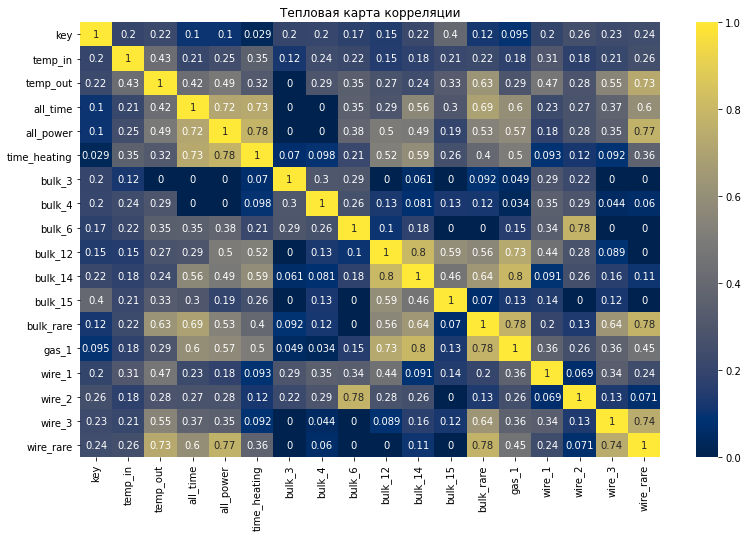

In [95]:
plt.figure(figsize=(13, 8))
sns.heatmap(df_all.phik_matrix(), annot=True, cmap='cividis')
plt.title("Тепловая карта корреляции")
plt.show()

По тепловой карте можем увидеть, что мультиколиниарности нет.

Относительно целевого признака - зависимость к остальным ниже среднего.

Высокая колиниарность наблюдается у признаков:  полной мощности к времени; температуры на входе и времени нагрева.

## Подготовка данных

Целевой признак определим как температуру на выходе продукта.

In [96]:
#Создаем переменные с входным и целевым признаками
X = df_all.drop(['temp_out', 'key'], axis=1)
y = df_all['temp_out']

In [97]:
X.head(1)

,temp_in,all_time,all_power,time_heating,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,bulk_rare,gas_1,wire_1,wire_2,wire_3,wire_rare
0,1571.0,1714.0,3.718736,1098.0,0.0,43.0,0.0,206.0,150.0,154.0,0.0,29.749986,60.059998,0.0,0.0,0.0


In [98]:
#Разбивка данных на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.25)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1743, 16)
(581, 16)
(1743,)
(581,)


### Модель DecisionTreeRegressor

In [99]:
model_dtr = DecisionTreeRegressor()

In [100]:
parameters = {
    'min_samples_leaf': range(1, 30),
    'min_samples_split': range(2, 30),
    'max_depth': range(2, 30)
}

In [101]:
rs_model_dtr = RandomizedSearchCV(
    model_dtr,
    parameters,
    n_jobs=-1,
    cv=5,
    scoring='neg_mean_absolute_error'
)

In [102]:
model_dtr = rs_model_dtr.fit(X_train, y_train) 
print(f'Лучшая MAE: {round(-model_dtr.best_score_, 2)} при параметрах ,{model_dtr.best_params_}')

Лучшая MAE: 7.1 при параметрах ,{'min_samples_split': 5, 'min_samples_leaf': 29, 'max_depth': 16}


### Модель CatBoostRegressor

In [103]:
model_cbr = CatBoostRegressor(iterations=200, learning_rate=0.5, verbose=0)

In [104]:
score_lr = cross_val_score(model_cbr, X_train, y_train, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5))
print(f'Лучшая MAE: {round(np.mean(-score_lr), 2)}')

Лучшая MAE: 6.59


### Модель LinearRegression

In [105]:
num_columns = X.columns.to_list()
num_columns

['temp_in',
 'all_time',
 'all_power',
 'time_heating',
 'bulk_3',
 'bulk_4',
 'bulk_6',
 'bulk_12',
 'bulk_14',
 'bulk_15',
 'bulk_rare',
 'gas_1',
 'wire_1',
 'wire_2',
 'wire_3',
 'wire_rare']

In [106]:
# создаем переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

# обучение и трансформирование количественных признаков из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train[num_columns])

# преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[num_columns])

In [107]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

In [108]:
X_train_scaled

,temp_in,all_time,all_power,time_heating,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,bulk_rare,gas_1,wire_1,wire_2,wire_3,wire_rare
0,0.065380,-0.349958,0.255610,-0.546756,-0.130929,-0.638182,-0.399311,-0.334713,-0.674256,-0.219609,-0.280319,-1.015224,-0.131191,-0.532480,-0.123611,-0.149181
1,-0.229736,-0.077275,-0.643588,-0.582938,0.681014,-0.638182,-0.399311,-0.040239,-0.674256,-0.207839,-0.280319,-0.296371,2.043627,0.355010,-0.123611,-0.149181
2,-0.777809,-0.234874,-0.280681,0.023109,1.719237,-0.638182,0.911252,-1.339767,-0.167788,-1.420171,-0.280319,-0.098139,0.623599,1.211407,-0.123611,-0.149181
3,-1.325882,0.907901,2.028209,2.519663,0.907294,-0.638182,-0.399311,1.291297,1.487498,0.368901,-0.280319,1.376049,0.423174,0.827627,-0.123611,-0.149181
4,-1.072925,-0.635102,0.076664,-0.245240,1.759169,-0.638182,2.455203,-1.339767,-0.884255,-1.420171,0.379382,-0.088789,-0.117261,0.353233,-0.123611,-0.149181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,0.739931,0.458561,0.747031,1.214098,1.306610,-0.638182,1.844804,1.272092,0.746325,0.969182,-0.280319,-0.065653,0.172288,0.797024,-0.123611,-0.149181
1739,-0.103258,-0.398337,0.264048,-0.163831,-0.636730,3.969278,-0.399311,-0.027435,0.585738,-0.196069,-0.280319,-0.137679,-0.168504,-0.532480,-0.123611,-0.149181
1740,0.529134,2.080730,1.054239,1.313598,-0.303966,-0.638182,-0.399311,-1.339767,1.228088,-1.420171,-0.280319,0.557623,0.972209,0.353233,-0.123611,-0.149181
1741,0.697772,1.221633,1.368234,0.137685,-0.636730,-0.638182,-0.399311,-0.347516,-0.068965,-0.207839,-0.280319,1.887248,0.372287,2.404499,-0.123611,-0.149181


In [109]:
# модель линейной регрессии
model_lr  = LinearRegression()

# обучение модели на тренировочных данных
model_lr.fit(X_train_scaled, y_train)

# предсказания модели на тестовых данных 
predictions = model_lr.predict(X_train_scaled)


In [110]:
# рассчитайте MAE для линейной регрессии
mae = mean_absolute_error(y_train, predictions)
print(f'MAE: {round(mae, 2)}')

MAE: 6.02


Были спользованы три модели регресии: LinearRegression, CatBoostRegressor, DecisionTreeRegressor.

Использована метрика МАЕ (средняя абсолютная ошибка). По условию задачи должна быть ниже МАЕ < 6.8
Модель DecisionTreeRegressor немного не долша до порога, с результатом МАЕ = 7.1. Две другие, т.е. модель CatBoostRegressor и LinearRegression прошли необходимый порог.
По результату модель Линейной регрессии показала лучший параметр - 6.02.

## Выбор лучшей модели

In [111]:
predictions_test = model_lr.predict(X_test_scaled)

In [112]:
# рассчитайте MAE для линейной регрессии
mae = mean_absolute_error(y_test, predictions_test)
print(f'MAE: {round(mae, 2)}')

MAE: 5.82


Метрика на тестовой выброке - 5.82, что выполняет условия задачи.

In [113]:
explainer = shap.LinearExplainer(model_lr, X_train_scaled)
shap_values = explainer(X_test)

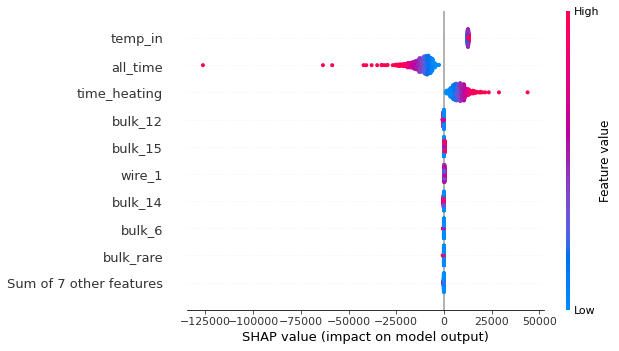

In [114]:
shap.plots.beeswarm(shap_values) 

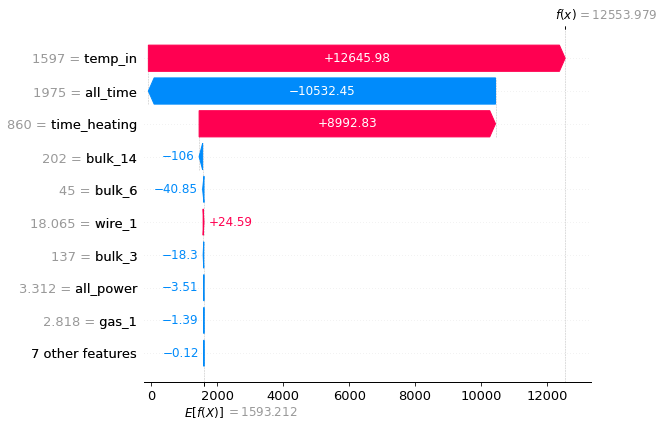

In [115]:
shap.plots.waterfall(shap_values[1]) 

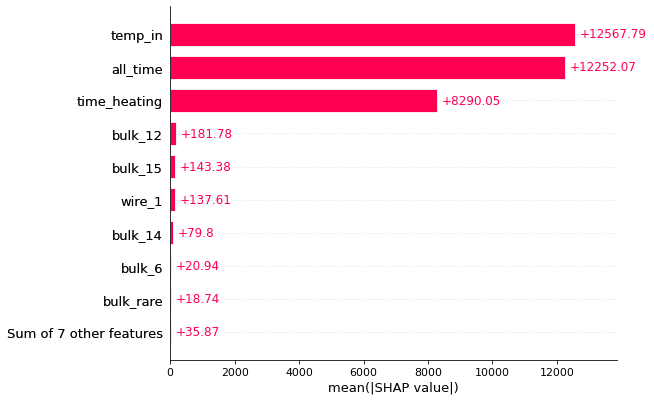

In [116]:
shap.plots.bar(shap_values) 

Исходя из графиков важности признаков можем сказать, что на модель влиют такие признаки как начальная температура сырья, время процесса и время нагрева. 

## Вывод

В полученной задаче рассмотрели 7 датасетов относящихся к одному процессу - именно получения необходимого продукта из первичного сырья, путем нагрева, и добавления присадок.

По датасетам провели первичный, а так же исследовательский анализ признаков. Часть данных была не пригодна к использованию - ее удалили. Оставшуюся информация объеденили в один. Был определен целевой признак - температура готового продукта на выходе. 

После проведения подготовки данных были спользованы три модели регресии: LinearRegression, CatBoostRegressor, DecisionTreeRegressor.

Использована метрика МАЕ (средняя абсолютная ошибка). По условию задачи должна быть ниже МАЕ < 6.8
Все модели перешли желаемый порог.
По результату модель Линейной регрессии показала лучший параметр - 6.02 на тренировочной, и 5.82 на тестовой.

На модель влияют такие признаки как температура сырья на входе, время нагрева дугой, и время процесса. На эти моменты нужно будет обратить внимание, при подготовке возможных процессов, для улучшения.
